# Overview

This mini-project uses data from [Histopathologic Cancer Detection competition on Kaggle](https://www.kaggle.com/competitions/histopathologic-cancer-detection). The goal of competition was to identify metastatic cancer in small image patches taken from larger digital pathology scans.

# Imports

In [ ]:
!pip install timm -q
!pip install kaleido -q
!pip install optuna -q

In [4]:
from pathlib import Path
from time import perf_counter

import kaleido
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from PIL import Image
import timm
import tqdm

from fastai.vision.all import * # Needs to be imported after timm

# Data



First, we are going to load the data and look at some basic stats.

In [ ]:
# Path Constants
INPUT_DIR = Path("/kaggle/input/histopathologic-cancer-detection").resolve()	
TRAIN_LABELS_FILEPATH = INPUT_DIR / "train_labels.csv"
TRAIN_DIR = INPUT_DIR / "train"
TEST_DIR = INPUT_DIR / "test"
SAMPLE_SUBMISSION_FILEPATH = INPUT_DIR / "sample_submission.csv"

In [ ]:
train_labels_df = pd.read_csv(TRAIN_LABELS_FILEPATH)
sample_submission_df = pd.read_csv(SAMPLE_SUBMISSION_FILEPATH)
print(f"train_labels_df.shape: {train_labels_df.shape}")
print(f"sample_submission_df.shape: {sample_submission_df.shape}")

train_labels_df.shape: (220025, 2)
sample_submission_df.shape: (57458, 2)


In [ ]:
def prepare_paths_and_labels(df):
    """Prepare paths and labels for training.

    Args:
        df (pd.DataFrame): DataFrame with columns "id", "label".
    """
    df["path"] = df["id"].apply(lambda x: str(TRAIN_DIR / f"{x}.tif"))
    df["label"] = df["label"].astype("str")
    return df[["id", "path", "label"]]

train_df = prepare_paths_and_labels(train_labels_df)

In [ ]:
def collect_all_image_shapes(df, subsample=2500):
    """Collect all image shapes.

    Args:
        df (pd.DataFrame): DataFrame with columns "id", "path", "label".
        subsample (int, optional): Subsample size.
    """
    image_shapes = []
    for path in tqdm.tqdm(df["path"].iloc[:subsample], mininterval=1):
        image_shapes.append(np.array(Image.open(path)).shape)
    return image_shapes

image_shapes = collect_all_image_shapes(train_df)
print(f"Example shape: {image_shapes[0]}")
print(f"Number of different shapes: {len(set(image_shapes))}")

100%|██████████| 2500/2500 [00:10<00:00, 244.64it/s]

Example shape: (96, 96, 3)
Number of different shapes: 1


From the preliminary look at the data, we can see that the dataset is fairly large. The training (public) set contains 220025 images, while the test (private) contains 57458 images. All the images in the public set seem to have the same shape of 96x96.

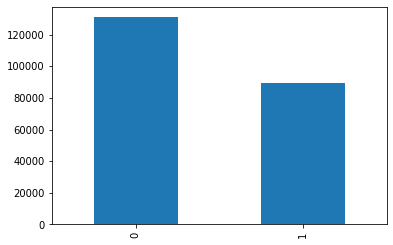

In [ ]:
train_df["label"].value_counts().plot(kind="bar")
plt.show() 

The target is a binary value indicating if the images contains metastatic cancer. The distribution of the labels is a but unbalanced, but the difference is much slower than would be expected considering low rate of cancer in general population.

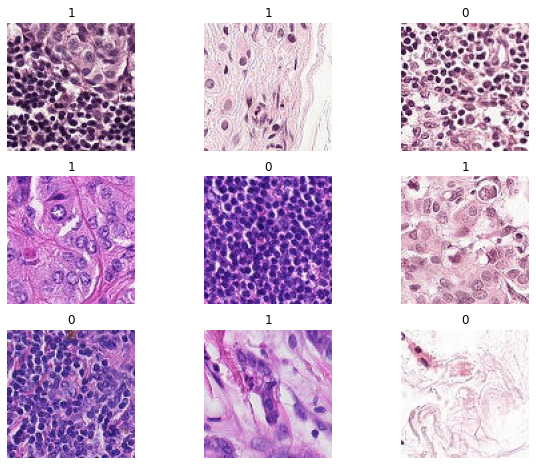

In [ ]:
def show_batch_of_images(df, batch_size=16):
    """Show a batch of images.

    Args:
        df (pd.DataFrame): DataFrame with columns "id", "path", "label".
        batch_size (int, optional): Batch size to use when loading.
    """
    data = ImageDataLoaders.from_df(
        path="/",
        df=df,
        item_tfms=None,
        batch_tfms=None,
        size=96,
        bs=batch_size,
        fn_col="path",
        label_col="label",
    )
    data.show_batch(figsize=(10, 8))
show_batch_of_images(train_df)

From a sample of training images, it seems that the images are ok. However, I do not have the knowledge required to work with these kinds of images and it's completely possible that there might be some problems with the data.

Based on all this, my conclusion is that we can start training baseline vision models without any problems and from there we can determine if anything needs to be done with the data.

# Preparing Data and Hyperparameters

Before training the baseline model, we need to define the hyperparameters for it and set up the data loading pipeline with data augmentations.

In [ ]:
# Hyperparameters for the baseline model
hyperparameters = {
    "arch": "resnet18",
    "batch_size": 1024,
    "size": 96,
    "seed": 0,
    "subsample": True,
    "valid_pct": 0.2,
    "num_workers": 2,
    "lr": 0.001,
    "weight_decay": 0.01,
    "epochs": 5,
}

In [ ]:
# In order to facilitate faster iteration the first experiments can be run with a reduced dataset
if hyperparameters["subsample"]:
    train_df_sub = train_df.sample(2048, random_state=hyperparameters["seed"])
    hyperparameters["batch_size"] = 64

In [ ]:
def get_transforms(
    max_rotate=10.0, min_zoom=1.0, max_zoom=1.1,
    max_lighting=0.2, max_warp=0.2,
    p_affine=0.75, p_lighting=0.75, **kw
):
    """Returns a list of transforms to be used in data augmentation."""
    return [
        Normalize.from_stats(*imagenet_stats),
        *aug_transforms(
            flip_vert=True,
            max_rotate=max_rotate, min_zoom=min_zoom, max_zoom=max_zoom,
            max_lighting=max_lighting, max_warp=max_warp,
            p_affine=p_affine, p_lighting=p_lighting
        )
    ]

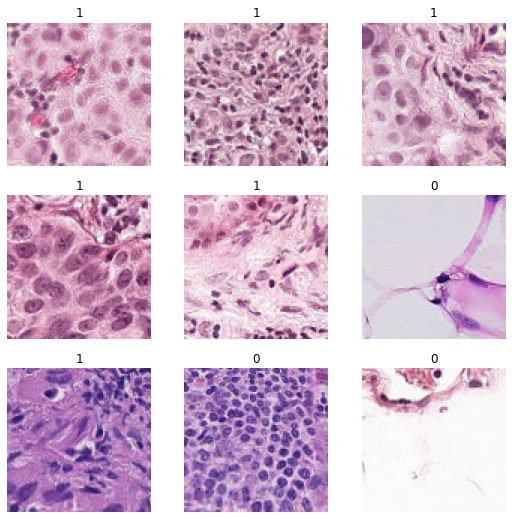

In [ ]:
def prepare_data(df, hyperparameters):
    """Prepare data for training.
    
    Args:
        df (pd.DataFrame): DataFrame with columns "id", "path", "label".
        hyperparameters (dict): Dictionary with hyperparameters.
    """
    data = ImageDataLoaders.from_df(
        path="/",
        df=df,
        ds_tfms=get_transforms(),
        size=hyperparameters["size"],
        bs=hyperparameters["batch_size"],
        val_bs=hyperparameters["batch_size"]*2,
        num_workers=hyperparameters["num_workers"],
        fn_col="path",
        label_col="label",
        valid_pct=hyperparameters["valid_pct"],
        item_tfms=None,
        batch_tfms=get_transforms()
    )
    return data

dataloaders = prepare_data(train_df_sub, hyperparameters)
dataloaders.show_batch()

Here, we can see examples of the training images after data augmentations. The augmentations seem to be ok and the images are still similar to the ones without augmentations (see above). However, it's difficult to tell if any important information was lost.

Since the competition's metric is area under the ROC curve, it's the metric we need to focus on. I also decided to add accuracy, precision and recall since they can be used to notice if there is any problems with specific class distribution/prediction.

In [ ]:
def get_metrics():
    """Get a list of metrics for cancer dataset."""
    return [accuracy, Precision(), Recall(), RocAucBinary()]

# Training a Baseline Model

With the data loading pipeline done, we can train a baseline model. The learning rate is going to be set using the learning rate finder (it's not always optimial, but usually close enough and doesn't use as much compute as normal tuning).

In [ ]:
def prepare_learner(dataloaders, hyperparameters):
    """Prepare pretrained learner for training.

    Args:
        dataloaders (ImageDataLoaders): DataLoaders for training.
        hyperparameters (dict): Dictionary with hyperparameters.
    """
    learner = vision_learner(
        dataloaders,
        hyperparameters["arch"],
        pretrained=True,
        metrics=get_metrics(),
        loss_func=LabelSmoothingCrossEntropy(),
        cbs=[ShowGraphCallback()],
        lr=hyperparameters["lr"],
        wd=hyperparameters["weight_decay"],
    ).to_fp16()
    return learner

learner = prepare_learner(dataloaders, hyperparameters)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


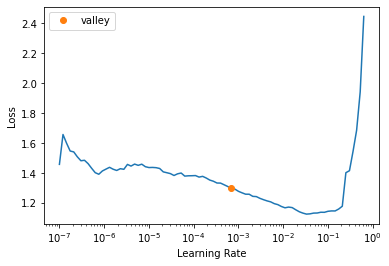

In [ ]:
lr_find = learner.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,roc_auc_score,time
0,1.178555,0.585952,0.777506,0.759124,0.641975,0.832059,00:05
1,0.966413,0.574767,0.826406,0.882353,0.648148,0.874294,00:04
2,0.864781,0.553056,0.811736,0.897196,0.592593,0.881342,00:04
3,0.799933,0.526055,0.819071,0.907407,0.604938,0.886552,00:04
4,0.775710,0.535088,0.814181,0.913462,0.586420,0.886040,00:04


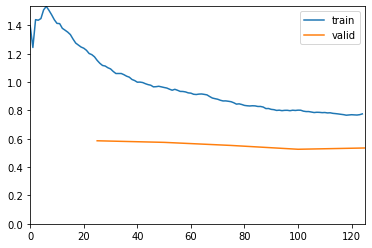

In [ ]:
learner.fit_one_cycle(5, lr_find.valley)

The training of the baseline model seems to be fine. From the plot, it can be seen that the model is learning and is not overfitting. The only concern is the low recall score, but it's probably due to not training for enough epochs.

# Hyperparameter Optimization

Since the baseline model didn't show any problems, the next step is to find the best hyperparameters to use during training. We are still going to be using only a subsample of all data in order to speed up the process. This shouldn't cause any big problems, but it would definitely be better to manually construct the reduced dataset, which better resembles the full one.

For the hyperparameter optimization problem, I am using `optuna`. It's an optimization library which allows to optimize any arbitrary function with automatic algorithms for finding optimal parameters.

It requires an objective function to optimize and hyperparameters to be sampled. So, we are going to define the objective function.

In [ ]:
def train(dataloaders, hyperparameters, cbs=[]):
    """Train a model using the given hyperparameters and callbacks with the learning rate finder.

    Args:
        dataloaders (ImageDataLoaders): DataLoaders for training.
        hyperparameters (dict): Hyperparameters for training.
        cbs (list, optional): Callbacks to use during training.
    """
    learner = prepare_learner(dataloaders, hyperparameters)
    lr_find = learner.lr_find()
    lr = lr_find.valley
    learner.fit_one_cycle(
        hyperparameters["epochs"], lr,
        cbs=cbs
    )
    final_roc_auc = learner.recorder.values[-1][-1]
    return learner, final_roc_auc

For this optimization run, we are going to search through different model architectures, weight decay and number of epochs.

In [ ]:
def objective(trial, dataloaders, hyperparameters):
    """Objective function for Optuna hyperparameter optimization.

    Args:
        trial (optuna.trial.Trial): Optuna trial object.
        dataloaders (ImageDataLoaders): DataLoaders for training.
        hyperparameters (dict): Hyperparameters for training.
    """

    arch_pos = [
        "resnet18", "convnext_tiny_in22k", "convnext_small", "efficientnet_b3" 
    ]
    arch = trial.suggest_categorical("arch", arch_pos)
    hyperparameters["weight_decay"] = trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True)
    hyperparameters["epochs"] = trial.suggest_int("epochs", 3, 12)
    cbs = []#optuna.integration.FastAIV2PruningCallback(trial, monitor="roc_auc_score")]
    
    learner, roc_auc = train(dataloaders, hyperparameters, cbs)
    return roc_auc

The outputs for hyperoptmizations were pruned in order to make the notebook more readable (the runs produced a lot of logs). Also, `optuna` outputs dynamic plots. They were saved and are now displayed as static images.

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, dataloaders, hyperparameters), n_trials=50)

In [10]:
def show_image(path):
    """Loads image from the path and display it in Jupyter Notebook."""
    from IPython.core.display import Image, display
    display(Image(filename=path, unconfined=True))

0.9306992552606588 {'arch': 'convnext_small', 'weight_decay': 0.023379304722516744, 'epochs': 12}


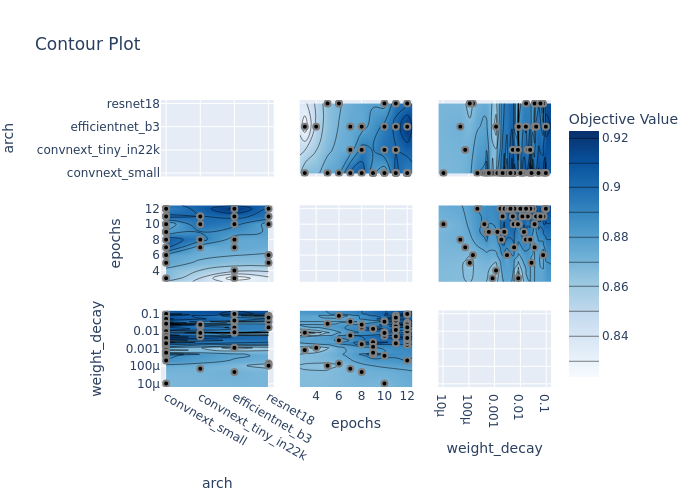

In [12]:
# print(study.best_trial.value, study.best_params)
# best_arch = study.best_params["arch"]
# fig = optuna.visualization.plot_contour(study)
# fig.write_image("hp1_contour.png")
# fig
print("0.9306992552606588 {'arch': 'convnext_small', 'weight_decay': 0.023379304722516744, 'epochs': 12}")
show_image("hp1_contour.png")

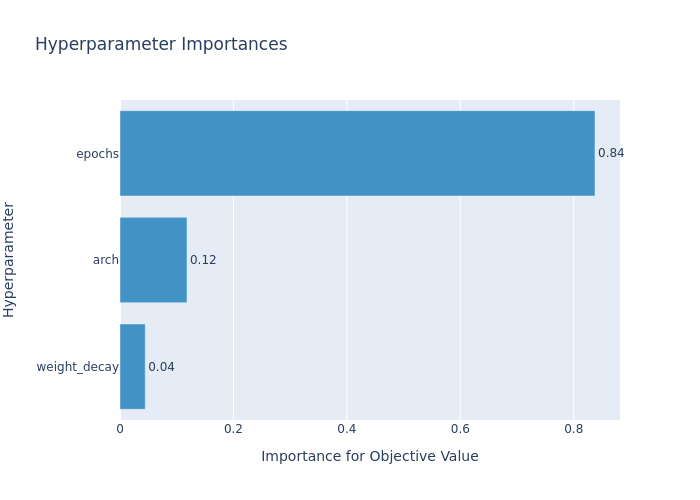

In [13]:
# fig = optuna.visualization.plot_param_importances(study)
# fig.write_image("hp1_importances.png")
# fig
show_image("hp1_importances.png")

After this optimization run, the ROC-AUC improved from 0.886 to 0.931. The most important hyperparameter by a wide margin is the number of training epochs, which makes sense considering the baseline model training was not overfitted at all.

The architecture also seemed to matter, but not as much. Later, we are going to be using the model architecture, which performed best here.

Since the first hyperparameter optimization didn't reveal any more problems, we are going to be doing a second run. With this run, we are going to increase the maximum possible number of training epochs and add data augmentation hyperparameters.

In [ ]:
def objective(trial, hyperparameters):
    """Objective function for Optuna hyperparameter optimization.

    Args:
        trial (optuna.trial.Trial): Optuna trial object.
        hyperparameters (dict): Hyperparameters for training.
    """

    hyperparameters["arch"] = best_arch # "convnext_tiny_in22k"
    hyperparameters["weight_decay"] = trial.suggest_float("weight_decay", 1e-8, 1e-3, log=True)
    hyperparameters["epochs"] = trial.suggest_int("epochs", 3, 20)
    hyperparameters["max_rotate"] = trial.suggest_float("max_rotate", 0.0, 30.0)
    hyperparameters["min_zoom"] = trial.suggest_float("min_zoom", 0.9, 1.09)
    hyperparameters["max_zoom"] = trial.suggest_float("max_zoom", 1.1, 1.3)
    hyperparameters["max_lightning"] = trial.suggest_float("max_lightning", 0.0, 0.3)
    hyperparameters["max_warp"] = trial.suggest_float("max_warp", 0.0, 0.3)
    hyperparameters["p_affine"] = trial.suggest_float("p_affine", 0.2, 0.9)
    hyperparameters["p_lighting"] = trial.suggest_float("p_lighting", 0.2, 0.9)
    cbs = []#optuna.integration.FastAIV2PruningCallback(trial, monitor="roc_auc_score")]
    
    dataloaders = prepare_data(train_df_sub, hyperparameters)
    learner, roc_auc = train(dataloaders, hyperparameters, cbs)
    return roc_auc

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, hyperparameters), n_trials=30)

0.9500360490266763 {'weight_decay': 8.134762053180836e-06, 'epochs': 20, 'max_rotate': 6.165309485769476, 
'min_zoom': 0.9875882727787649, 'max_zoom': 1.1026005018147833, 'max_lightning': 0.15695052277114063, 
'max_warp': 0.12653633800963343, 'p_affine': 0.49161428486822034, 'p_lighting': 0.2236849554798448}


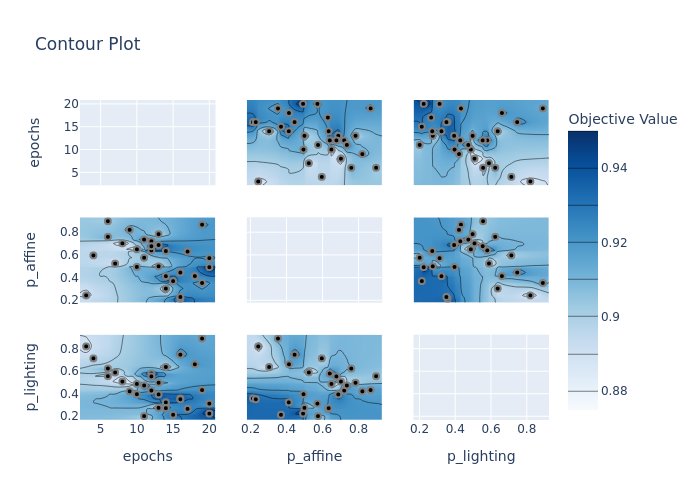

In [15]:
# print(study.best_trial.value, study.best_params)
# fig = optuna.visualization.plot_contour(study, params=["epochs", "p_affine", "p_lighting"])
# fig.write_image("hp2_contour.png")
# fig
print((
    "0.9500360490266763 {'weight_decay': 8.134762053180836e-06, 'epochs': 20, 'max_rotate': 6.165309485769476, \n"
    "'min_zoom': 0.9875882727787649, 'max_zoom': 1.1026005018147833, 'max_lightning': 0.15695052277114063, \n"
    "'max_warp': 0.12653633800963343, 'p_affine': 0.49161428486822034, 'p_lighting': 0.2236849554798448}"
))
show_image("hp2_contour.png")

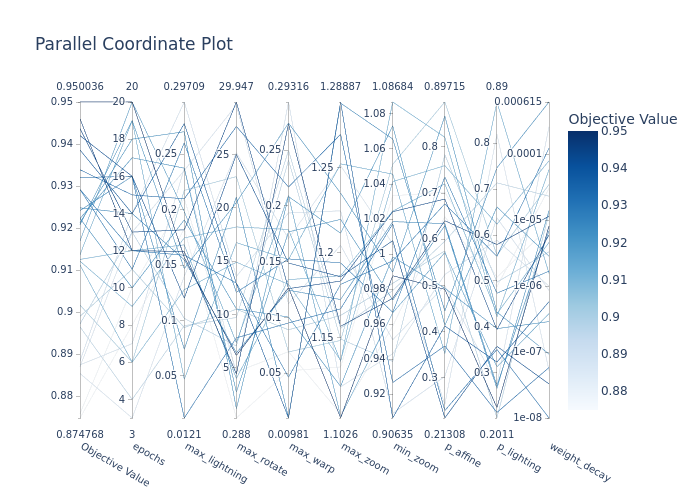

In [16]:
# fig = optuna.visualization.plot_parallel_coordinate(study)
# fig.write_image("hp2_pp_coord.png")
# fig
show_image("hp2_pp_coord.png")

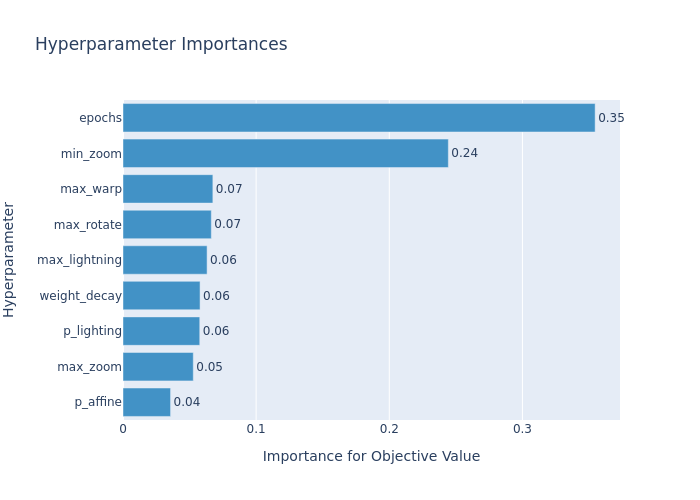

In [17]:
# fig = optuna.visualization.plot_param_importances(study)
# fig.write_image("hp2_importances.png")
# fig
show_image("hp2_importances.png")

After optimizing the second time, the ROC-AUC score improved from 0.931 to 0.950. Once again, the most important hyperparameter is the number of epochs and the best run was at the maximum number of epochs. The data augmentation hyperparameters also play a big role.

# Train Final Model

Even though there is still room for improvement, we are going to train a full model now. It's going to be using the hyperparameters from the best run and the full training dataset.

In [ ]:
# Clearing CPU and GPU memory to free up as much as possible for full training.

from time import sleep
import gc
gc.collect()
torch.cuda.empty_cache()
sleep(30)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,roc_auc_score,time
0,0.724604,0.486982,0.838859,0.809249,0.787295,0.910242,12:44
1,0.556351,0.422681,0.867629,0.833584,0.840654,0.938065,08:15
2,0.434029,0.374221,0.894171,0.891256,0.841047,0.956339,07:54
3,0.373632,0.346970,0.913578,0.926730,0.853909,0.967979,07:48
4,0.348978,0.328740,0.925259,0.946918,0.863682,0.974433,07:48
5,0.333128,0.314672,0.934826,0.940642,0.895417,0.978611,07:47
6,0.324724,0.307868,0.938689,0.942213,0.903898,0.980620,07:52
7,0.320874,0.301470,0.941484,0.942472,0.910975,0.982596,07:50
8,0.314260,0.297388,0.943506,0.949736,0.908448,0.983890,07:43
9,0.310549,0.295297,0.945620,0.945327,0.918726,0.983882,07:49


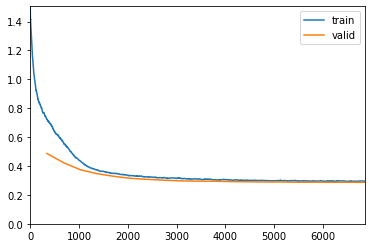

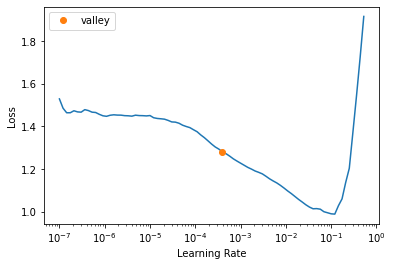

In [ ]:
for k, v in study.best_trial.params.items():
    hyperparameters[k] = v
hyperparameters["batch_size"] = 512
dataloaders = prepare_data(train_df, hyperparameters)
learner, _ = train(dataloaders, hyperparameters)

The full model seems to be performing well. It is still not overfitting since the validation loss is about the same as the training loss.

# Creating Submission

In [ ]:
def create_submission(learner):
    """Create submission file.

    Args:
        learner (Learner): Learner to use for predictions.
    """
    test_df = sample_submission_df.copy()
    test_df["path"] = test_df["id"].apply(lambda x: str(TEST_DIR / f"{x}.tif"))
    test_dl = learner.dls.test_dl(test_df)
    predictions = learner.get_preds(dl=test_dl)[0]
    test_df["label"] = predictions[:, 1]
    test_df[["id", "label"]].to_csv("submission.csv", index=False)

In [ ]:
create_submission(learner)

# Results

|Model|Score|
|-|-|
|Baseline|0.886|
|1st optimization|0.931|
|2nd optimization|0.950|
|Final model|0.9859|
|Public score|0.9498|
|Private score|0.9536|

The final model got a private score of 0.9536. It seems that the validation split used differs in some ways from the private set, which is used in the competition and there is still room for improvement.

From here there is a few possible things to do. Firstly, we can start optimizing learning rate directly, since it seems that it is a bit too conservative (models are not overfitting at all). Secondly, we can improve the subsampled dataset either by carefully choosing the data to be used or by just increasing its size. The third thing is trying to find data augmentations that are better suited for these kinds of images. Finally, just training for longer might improve the model's performance.